# Import libraries and data

In [ ]:
# import libraries to navigate within directories
import os
import sys
import re

# the usual suspects
import pandas as pd
import numpy as np

# Import sparse to help process NL data into chunks
from scipy import sparse # if we don't use this your computer's memory will see heaven
import pickle # we need to use this for JSON because we're storing Spare matrices AND its a large dataset

# NLP libraries
## TF-IDF calculation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize # normalize TF/TF-IDF scores

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter-specific imports
from IPython.display import clear_output
%matplotlib inline 

# Suppress warnings (optional)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
df_metadata_transcript = pd.read_csv('clean_metadata_transcript.csv')
df_metadata_transcript.head(5)

,channel_name,video_title,video_url,publish_date,video_length,views,likes,comments,transcript_filename,"Tier (1, 2, or 3)",content,preprocessed_content,total_words,unique_words
0,Black Girls Code,Have You Ever Thought About Working at Google?...,https://www.youtube.com/watch?v=ahQQpYG0Lhk,4/26/24,6:26,199330,5625,4,haveyoueverthoughtaboutworkingatgoogleepisode8...,1,hello everyone and welcome back to codal along...,"['hello', 'everyone', 'welcome', 'back', 'coda...",546,281
1,Black Girls Code,Tutorial 4: How to Code Animated Art In JavaSc...,https://www.youtube.com/watch?v=I49CXUIXvM8,4/28/23,11:18,84000,179,8,tutorial4howtocodeanimatedartinjavascriptcodea...,1,what's up for the encoders welcome back to the...,"['whats', 'encoders', 'welcome', 'back', 'four...",711,271
2,Black Girls Code,CODE Along: Win $2500!,https://www.youtube.com/watch?v=fZKyNSH2mmM,8/25/23,2:19,139194,344,18,codealongwin2500.txt,1,hey what's up everyone I'm Cheyenne and I'm yo...,"['hey', 'whats', 'everyone', 'im', 'cheyenne',...",209,152
3,Black Girls Code,Don't Know What Career to Choose? Actress and ...,https://www.youtube.com/watch?v=ohceCkLK8Wo,8/21/23,0:44,1143,40,2,dontknowwhatcareertochooseactressandgamerellab...,1,this question means so much to me because when...,"['question', 'mean', 'much', 'whenever', 'anyt...",61,53
4,Black Girls Code,Watch Actress Ella Balinska Recap Her Career i...,https://www.youtube.com/watch?v=jAYK6vJbhxU,8/19/23,0:48,3493,117,10,watchactressellabalinskarecaphercareerin60seco...,1,60 seconds okay so I started off uh with a cou...,"['second', 'started', 'couple', 'writer', 'pas...",64,56


## Term Frequency Inverse Document Frequency (TF-IDF)
TF-IDF is calculated by multiplying two values: by a measure of how unique/rare that word is across all documents by: taking the Term Frequency of a specific word * the log(total # of documents / # of documents containing the word). 

TF-IDF scores are evaluated by both the TF and IDF portions in interpretation. High TF-IDF scores indicate a word is frequently used in a specific document (high TF) and rare across all documents (high IDF); low TF-IDF scores indicate a word is rarely used in a document (low TF) and common across all documents (low IDF). In this way, TF-IDF can particularly identify distinctive vocabulary used amongst a YouTube channel or per YouTube video.

ALSO! ALSO ALSO ALSO! A lot of these take nearly a minute to run because we're processing so much data, so thanks so much for your patience...

### Calculate TF-IDF for the Corpus

In [ ]:
# # Initialize TF-IDF Vectorizer with the parameters that worked for CountVectorizer
# tfidf_vectorizer = TfidfVectorizer(
#     min_df=1,  # Include terms that appear in at least 1 document
#     max_df=1.0,  # Include all terms
#     token_pattern=r'(?u)\b\w+\b',  # Consider any word character
#     stop_words=None  # Don't remove stop words since we've already preprocessed
# )

# # Prepare the text data by joining the preprocessed tokens
# corpus_texts = df_metadata_transcript['preprocessed_content'].apply(
#     lambda x: ' '.join(x) if isinstance(x, list) else str(x)
# )

# # Calculate TF-IDF
# tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_texts)

# # Get feature names (terms)
# feature_names = tfidf_vectorizer.get_feature_names_out()

# # Calculate average TF-IDF scores across all documents
# avg_tfidf_scores = tfidf_matrix.mean(axis=0).A1

# # Create DataFrame with terms and their TF-IDF scores
# tfidf_df = pd.DataFrame({
#     'term': feature_names,
#     'tfidf': avg_tfidf_scores
# })

# # Sort by TF-IDF score and get top 50 terms
# top_50_tfidf = tfidf_df.sort_values('tfidf', ascending=False).head(50)

# print("Top 50 words in the whole corpus by TF-IDF:")
# print(top_50_tfidf)

Top 50 words in the whole corpus by TF-IDF:
             term     tfidf
60720         let  0.064971
50772          im  0.056001
76719         one  0.050929
44071          go  0.048133
123183       want  0.046880
97953         see  0.045290
42948         get  0.035440
96634         say  0.035316
58485        know  0.033977
111950      thats  0.033108
41337    function  0.032321
72064        need  0.031033
64011        make  0.030951
112343      thing  0.030794
119923        use  0.029060
19192        code  0.028642
120676      value  0.026727
89905      really  0.026532
41849        game  0.026478
38254        file  0.025979
113460       time  0.024955
30630        dont  0.024704
34887       equal  0.024483
75229      number  0.024123
3110         also  0.023872
71336        name  0.023849
121768      video  0.023219
62488        look  0.023113
127080      youre  0.022920
120872   variable  0.022357
38753       first  0.022271
125600      would  0.022223
25561        data  0.022215
1166

### Calculate TF-IDF per YouTube Channel

In [ ]:
# def get_tfidf_by_channel(df):
#     channel_tfidf_dict = {}
    
#     # Initialize TF-IDF Vectorizer with the same parameters that worked for the corpus
#     tfidf_vectorizer = TfidfVectorizer(
#         min_df=1,  # Include terms that appear in at least 1 document
#         max_df=1.0,  # Include all terms
#         token_pattern=r'(?u)\b\w+\b',  # Consider any word character
#         stop_words=None  # Don't remove stop words since we've already preprocessed
#     )
    
#     # Process each channel
#     for channel, group in df.groupby('channel_name'):
#         try:
#             # Prepare channel documents by joining preprocessed tokens
#             channel_texts = group['preprocessed_content'].apply(
#                 lambda x: ' '.join(x) if isinstance(x, list) else str(x)
#             )
            
#             # Calculate TF-IDF for this channel
#             tfidf_matrix_channel = tfidf_vectorizer.fit_transform(channel_texts)
            
#             # Get feature names (terms)
#             feature_names = tfidf_vectorizer.get_feature_names_out()
            
#             # Calculate average TF-IDF scores for the channel
#             avg_tfidf_scores = tfidf_matrix_channel.mean(axis=0).A1
            
#             # Create DataFrame with terms and their TF-IDF scores
#             channel_tfidf_df = pd.DataFrame({
#                 'term': feature_names,
#                 'tfidf': avg_tfidf_scores
#             })
            
#             # Sort by TF-IDF score and get top 50 terms
#             top_50_tfidf = channel_tfidf_df.sort_values('tfidf', ascending=False).head(50)
            
#             # Store results in dictionary
#             channel_tfidf_dict[channel] = top_50_tfidf.set_index('term')['tfidf'].to_dict()
            
#         except ValueError as e:
#             print(f"Error processing channel {channel}: {e}")
#             continue
    
#     return channel_tfidf_dict

# # Calculate TF-IDF scores by channel
# channel_tfidf_scores = get_tfidf_by_channel(df_metadata_transcript)

# # Display results in a readable format
# print('\nTop 50 terms by TF-IDF score for each channel:')
# for channel, tfidf_scores in channel_tfidf_scores.items():
#     print(f"\n{'-'*50}")
#     print(f"Channel: {channel}")
#     print(f"{'-'*50}")
#     for term, score in tfidf_scores.items():
#         print(f"{term:<30} {score:>10.6f}")

# # Save results to CSV files
# def save_channel_tfidf_to_csv(channel_tfidf_dict):
#     # Create directory if it doesn't exist
#     output_dir = os.path.join('channel_tfidf_tables')
#     os.makedirs(output_dir, exist_ok=True)
    
#     for channel, tfidf_scores in channel_tfidf_dict.items():
#         try:
#             # Create DataFrame from the scores
#             channel_df = pd.DataFrame(
#                 list(tfidf_scores.items()), 
#                 columns=['Term', 'TF-IDF Score']
#             )
            
#             # Create safe filename
#             safe_channel_name = "".join(x for x in channel if x.isalnum() or x in (' ', '-', '_'))
            
#             # Save as CSV
#             csv_path = os.path.join(output_dir, f'{safe_channel_name}_tfidf_scores.csv')
#             channel_df.to_csv(csv_path, index=False)
            
#             print(f"Created TF-IDF table for {channel}")
            
#         except Exception as e:
#             print(f"Error saving channel {channel}: {e}")
#             continue

# # Save the results to CSV files
# save_channel_tfidf_to_csv(channel_tfidf_scores)


Top 50 terms by TF-IDF score for each channel:

--------------------------------------------------
Channel: AlvinBlox
--------------------------------------------------
player                           0.095750
game                             0.075825
part                             0.070638
say                              0.068865
want                             0.067452
script                           0.063084
go                               0.057111
see                              0.055764
one                              0.054742
im                               0.053167
function                         0.052747
get                              0.052623
let                              0.051321
value                            0.049490
data                             0.049385
event                            0.043142
set                              0.041813
table                            0.041518
got                              0.041101
need                            

## Calculate TF-IDF per YouTube Video


In [ ]:
# def get_tfidf_by_video(df):
#     video_tfidf_dict = {}
#     all_feature_names = None
#     combined_matrix = None
    
#     # Initialize TF-IDF Vectorizer
#     tfidf_vectorizer = TfidfVectorizer(
#         min_df=1,
#         max_df=1.0,
#         token_pattern=r'(?u)\b\w+\b',
#         stop_words=None
#     )
    
#     # First pass: get all terms to ensure consistent feature space
#     all_texts = []
#     for _, row in df.iterrows():
#         text = ' '.join(row['preprocessed_content']) if isinstance(row['preprocessed_content'], list) else str(row['preprocessed_content'])
#         all_texts.append(text)
    
#     # Fit vectorizer on all texts to get consistent feature space
#     combined_matrix = tfidf_vectorizer.fit_transform(all_texts)
#     all_feature_names = tfidf_vectorizer.get_feature_names_out()
    
#     # Store individual video scores
#     for idx, row in df.iterrows():
#         try:
#             video_title = row['video_title']
#             video_tfidf_scores = pd.Series(
#                 combined_matrix[idx].toarray()[0],
#                 index=all_feature_names
#             ).sort_values(ascending=False)
            
#             video_tfidf_dict[video_title] = video_tfidf_scores.head(50)
            
#         except Exception as e:
#             print(f"Error processing video {video_title}: {e}")
#             continue
    
#     return video_tfidf_dict, combined_matrix, all_feature_names

# # Calculate TF-IDF scores by video
# video_tfidf_dict, video_tfidf_scores, feature_names_video = get_tfidf_by_video(df_metadata_transcript)

# # Save results to CSV files
# def save_video_tfidf_to_csv(video_tfidf_scores):
#     # Create directory if it doesn't exist
#     output_dir = os.path.join('video_tfidf_tables')
#     os.makedirs(output_dir, exist_ok=True)
    
#     for video_title, tfidf_scores in video_tfidf_scores.items():
#         try:
#             # Create DataFrame from the scores
#             video_df = pd.DataFrame({
#                 'Term': tfidf_scores.index,
#                 'TF-IDF Score': tfidf_scores.values
#             })
            
#             # Create safe filename (use first 50 characters of title)
#             safe_title = "".join(x for x in video_title[:50] if x.isalnum() or x in (' ', '-', '_'))
            
#             # Save as CSV
#             csv_path = os.path.join(output_dir, f'{safe_title}_tfidf_scores.csv')
#             video_df.to_csv(csv_path, index=False)
            
#             print(f"Created TF-IDF table for video: {video_title[:50]}...")
            
#         except Exception as e:
#             print(f"Error saving video {video_title}: {e}")
#             continue
    
# # Print summary statistics
# print(f"\nTotal number of videos analyzed: {video_tfidf_scores.shape[0]}")
# print(f"Number of videos with successful TF-IDF calculation: {len(video_tfidf_dict)}")

# # Save the results to CSV files
# save_video_tfidf_to_csv(video_tfidf_dict)


Total number of videos analyzed: 16206
Number of videos with successful TF-IDF calculation: 16126
Created TF-IDF table for video: Have You Ever Thought About Working at Google? | E...
Created TF-IDF table for video: Tutorial 4: How to Code Animated Art In JavaScript...
Created TF-IDF table for video: CODE Along: Win $2500!...
Created TF-IDF table for video: Don't Know What Career to Choose? Actress and Game...
Created TF-IDF table for video: Watch Actress Ella Balinska Recap Her Career in 60...
Created TF-IDF table for video: Role Models: An Interview with Actress and Gamer E...
Created TF-IDF table for video: Don't Know Where to Start for a Career in Gaming? ...
Created TF-IDF table for video: #CODEAlong Tip: Watch & Learn How to Add A Disco F...
Created TF-IDF table for video: Role Models: How I Landed My Dream Job In Gaming W...
Created TF-IDF table for video: Role Models: An Interview with Professional Gamer ...
Created TF-IDF table for video: Tutorial 5: Code a Roblox Obby With M

# Producing a Normalized Matrix per YouTube Channel, per YouTube Video.

The goal of this visualization is to show all the words per YouTube Channel or YouTube Video. Each row is either a YouTube Channel or a YouTube Video depending on which codeblock, and each column is a word with each word in the corpus being represented. Each value within the cell is a normalized TF-IDF score, where all values in the cell should add up to 1.

Why use TF-IDF scores and normalize them? TF-IDF helps us identify what makes each YouTube Video/Channel unique by telling us words that are frequently used in the video/channel, but is rare across all other videos or channels. "TF" represents local importance because of how frequently it appears; "IDF" tells us how unique that words is across all videos/channels. When we normalize them, we balance out the transcript lengths, make TF-IDF scores comparable across different videos/channels, and ensure that comparison holds fairly because everything sums to 1.

## Create the Normalized Matrix
First, because of the sheer size of the corpus, we process all the data in batches.

Next, in this matrix, we utilize the Sparse library. The matrix is naturally going to be sparse with values because our columns are quite literally each word in the corpus, so a majority of the cells are going to be 0. The Sparse format only stores non-zero elements, reducing memory usage and being more computationally efficient. For example, imagine we had 10,000 videos with 50,000 unique words... That would be 500mil potential cells, but maybe only <= 5% contain non-zero values -- Sparse format stores that <= 5%.

In [7]:
def create_normalized_tfidf_matrix(df, by_channel=False, batch_size=1000):
    """
    Create normalized TF-IDF matrix using batches and sparse matrices
    Parameters:
        df: DataFrame containing the data
        by_channel: If True, create matrix by channel; if False, create by video
        batch_size: Number of documents to process in each batch
    """
    # Initialize vectorizer with our successful parameters
    vectorizer = TfidfVectorizer(
        min_df=1,
        max_df=1.0,
        token_pattern=r'(?u)\b\w+\b',
        stop_words=None,
        dtype=np.float32  # Use float32 instead of float64 to save memory
    )
    
    if by_channel:
        # Group by channel and join preprocessed content
        grouped_df = df.groupby('channel_name').agg({
            'preprocessed_content': lambda x: ' '.join([' '.join(tokens) if isinstance(tokens, list) else str(tokens) for tokens in x])
        }).reset_index()
        texts = grouped_df['preprocessed_content']
        labels = grouped_df['channel_name']
    else:
        # Process individual videos
        texts = df['preprocessed_content'].apply(
            lambda x: ' '.join(x) if isinstance(x, list) else str(x)
        )
        labels = df['video_title']
    
    # Fit vocabulary on all texts
    print("Fitting vocabulary...")
    vectorizer.fit(texts)
    
    # Process in batches
    n_samples = len(texts)
    n_batches = (n_samples - 1) // batch_size + 1
    
    print(f"Processing {n_batches} batches...")
    result_matrix = None
    
    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, n_samples)
        
        print(f"Processing batch {i+1}/{n_batches}")
        
        # Transform batch
        batch_texts = texts.iloc[start_idx:end_idx]
        batch_tfidf = vectorizer.transform(batch_texts)
        
        # Normalize batch
        batch_normalized = normalize_sparse_matrix(batch_tfidf)
        
        # Append to result
        if result_matrix is None:
            result_matrix = batch_normalized
        else:
            result_matrix = sparse.vstack([result_matrix, batch_normalized])
    
    return result_matrix, vectorizer.get_feature_names_out(), labels.values

def normalize_sparse_matrix(matrix):
    """
    Normalize sparse matrix rows to sum to 1
    """
    row_sums = np.array(matrix.sum(axis=1)).ravel()
    row_sums[row_sums == 0] = 1  # Avoid division by zero
    row_indices, col_indices = matrix.nonzero()
    matrix.data /= row_sums[row_indices]
    return matrix

def print_sample_results(matrix, terms, labels, n_samples=5):
    """
    Print sample results for n_samples documents
    """
    print(f"\nSample results for {n_samples} documents:")
    for i in range(min(n_samples, len(labels))):
        print(f"\nDocument: {labels[i]}")
        # Get non-zero elements for this document
        row = matrix[i].tocsr()
        non_zero_indices = row.indices
        values = row.data
        
        # Sort by value
        sorted_idx = np.argsort(-values)
        print("Top 10 terms:")
        for idx in sorted_idx[:10]:
            term_idx = non_zero_indices[idx]
            print(f"{terms[term_idx]}: {values[idx]:.4f}")

# Create normalized matrices for both channels and videos
print("Creating channel-level normalized TF-IDF matrix...")
channel_matrix, channel_terms, channel_labels = create_normalized_tfidf_matrix(
    df_metadata_transcript, 
    by_channel=True
)

print("\nCreating video-level normalized TF-IDF matrix...")
video_matrix, video_terms, video_labels = create_normalized_tfidf_matrix(
    df_metadata_transcript, 
    by_channel=False
)

# Print sample results for channels
print("\nChannel-level results:")
print_sample_results(channel_matrix, channel_terms, channel_labels)

# Print sample results for videos
print("\nVideo-level results:")
print_sample_results(video_matrix, video_terms, video_labels)

# Verify normalization
def verify_normalization(matrix, label):
    row_sums = np.array(matrix.sum(axis=1)).ravel()
    print(f"\nVerifying {label} row sums (should be close to 1):")
    print("Mean row sum:", np.mean(row_sums))
    print("Min row sum:", np.min(row_sums))
    print("Max row sum:", np.max(row_sums))

verify_normalization(channel_matrix, "channel")
verify_normalization(video_matrix, "video")

Creating channel-level normalized TF-IDF matrix...
Fitting vocabulary...
Processing 1 batches...
Processing batch 1/1

Creating video-level normalized TF-IDF matrix...
Fitting vocabulary...
Processing 17 batches...
Processing batch 1/17
Processing batch 2/17
Processing batch 3/17
Processing batch 4/17
Processing batch 5/17
Processing batch 6/17
Processing batch 7/17
Processing batch 8/17
Processing batch 9/17
Processing batch 10/17
Processing batch 11/17
Processing batch 12/17
Processing batch 13/17
Processing batch 14/17
Processing batch 15/17
Processing batch 16/17
Processing batch 17/17

Channel-level results:

Sample results for 5 documents:

Document: AlvinBlox
Top 10 terms:
player: 0.0154
game: 0.0115
say: 0.0108
want: 0.0104
script: 0.0104
go: 0.0095
im: 0.0091
get: 0.0086
see: 0.0084
one: 0.0083

Document: Beginner's Code Zone
Top 10 terms:
node: 0.0763
list: 0.0227
next: 0.0202
let: 0.0170
previous: 0.0166
linked: 0.0165
one: 0.0160
head: 0.0137
data: 0.0135
new: 0.0131

Docum

In [8]:
# Save matrices and metadata for 05.5-nlp-pca-analysis AND 08-nlp-interactive-visualizations.ipynb
matrices_to_save = {
    'normalized_channel_matrix': channel_matrix,  # This is already normalized
    'normalized_video_matrix': video_matrix,      # This is already normalized
    'channel_terms': channel_terms,
    'video_terms': video_terms,
    'channel_labels': channel_labels,
    'video_labels': video_labels
}

for name, data in matrices_to_save.items():
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

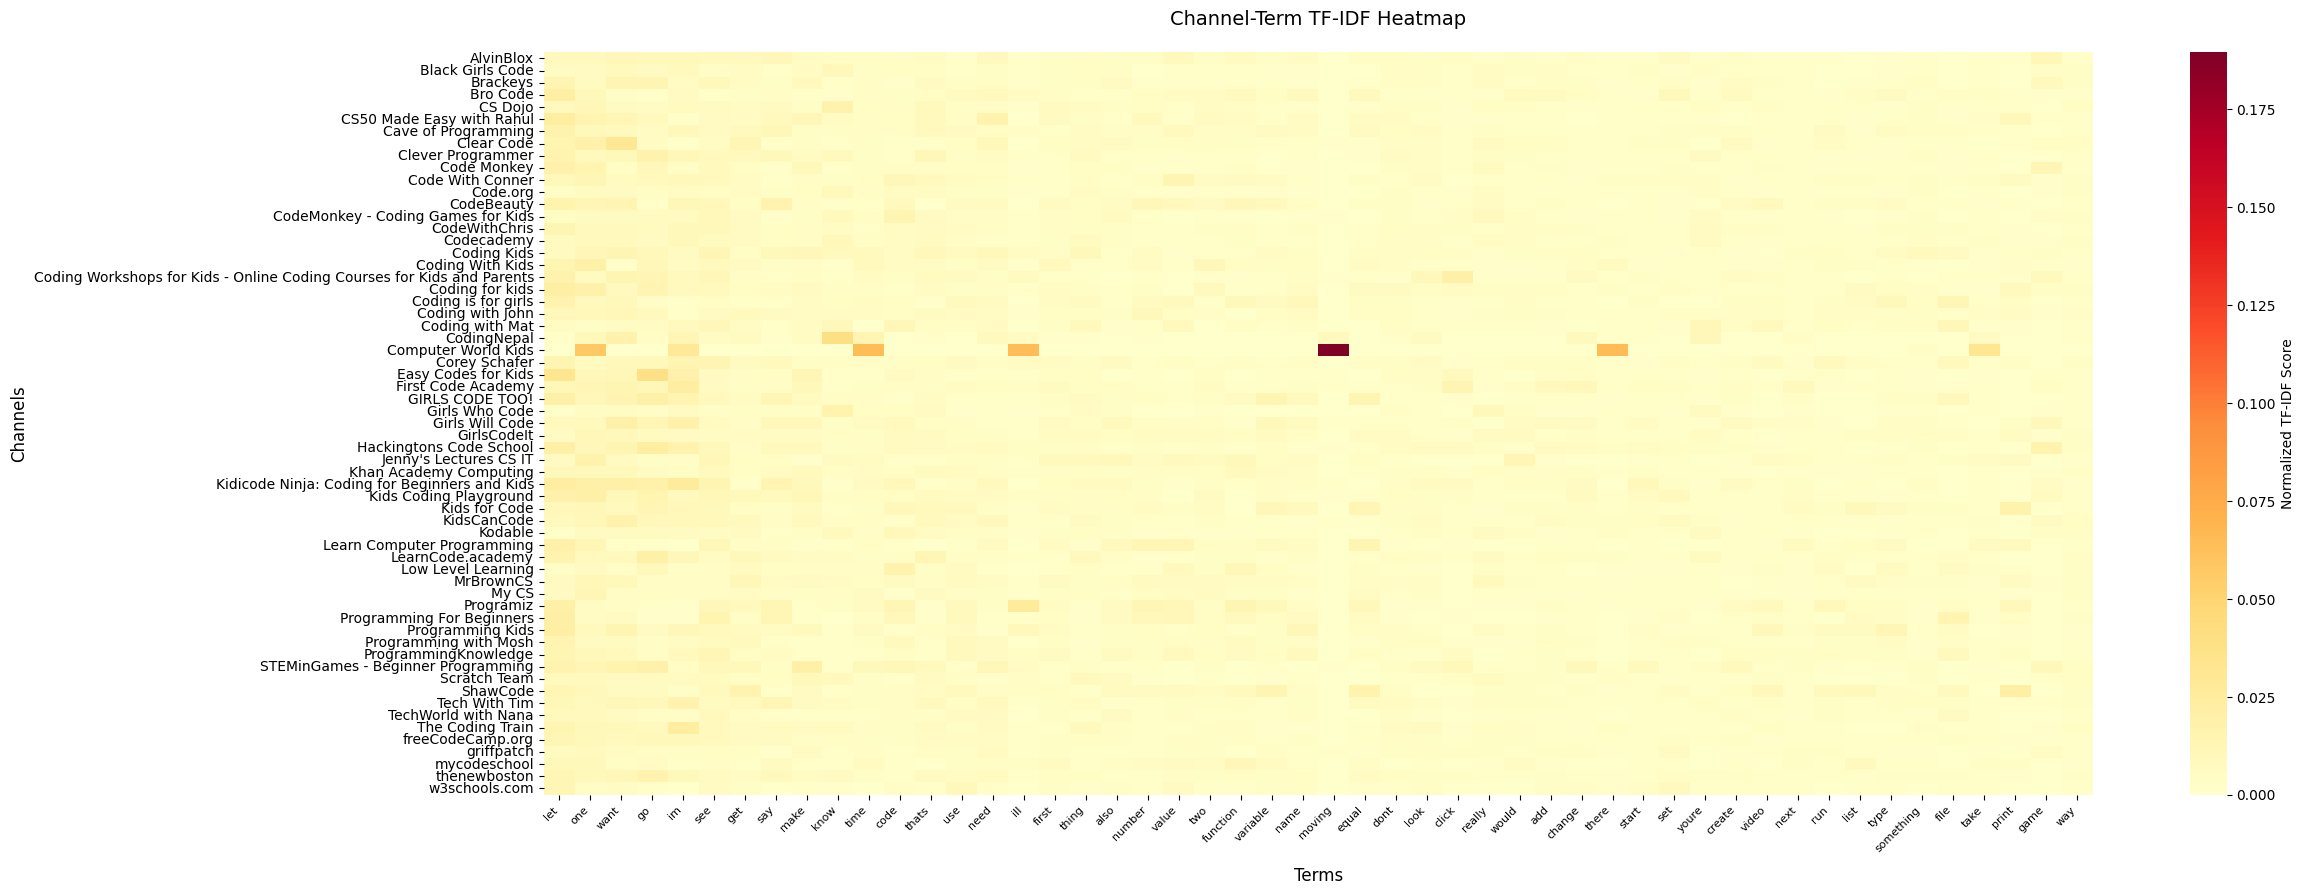

In [ ]:
# # Channel-level heatmap visualization
# def plot_channel_heatmap(channel_matrix, channel_terms, channel_labels, df_metadata_transcript, 
#                         n_top_terms=50, min_channel_videos=5, figsize=(25, 10)):
#     """
#     Create heatmap visualization for channel-level TF-IDF matrix
#     """
#     # Calculate term importance using mean
#     term_importance = np.array(channel_matrix.mean(axis=0)).flatten()
#     top_term_indices = np.argsort(-term_importance)[:n_top_terms]
    
#     # Filter channels by video count
#     channel_counts = df_metadata_transcript['channel_name'].value_counts()
#     valid_channels = channel_counts[channel_counts >= min_channel_videos].index
#     channel_mask = np.isin(channel_labels, valid_channels)
    
#     # Create subset matrix
#     subset_matrix = channel_matrix[channel_mask][:, top_term_indices].toarray()
    
#     # Create labels
#     term_labels = [channel_terms[i] for i in top_term_indices]
#     filtered_channels = channel_labels[channel_mask]
    
#     # Create figure
#     plt.figure(figsize=figsize)
    
#     # Create heatmap
#     sns.heatmap(subset_matrix, 
#                 xticklabels=term_labels,
#                 yticklabels=filtered_channels,
#                 cmap='YlOrRd',
#                 cbar_kws={'label': 'Normalized TF-IDF Score'})
    
#     # Adjust labels
#     plt.xticks(rotation=45, ha='right', fontsize=8)
#     plt.yticks(fontsize=10)
    
#     # Add labels and title
#     plt.xlabel('Terms', fontsize=12, labelpad=10)
#     plt.ylabel('Channels', fontsize=12)
#     plt.title('Channel-Term TF-IDF Heatmap', fontsize=14, pad=20)
    
#     # Adjust layout
#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.2)
    
#     # Save figure
#     plt.savefig('channel_tfidf_heatmap.png', 
#                 dpi=300, 
#                 bbox_inches='tight',
#                 pad_inches=0.5)
    
#     plt.show()

# # Create channel heatmap
# plot_channel_heatmap(channel_matrix, 
#                      channel_terms, 
#                      channel_labels, 
#                      df_metadata_transcript,
#                      n_top_terms=50,
#                      min_channel_videos=5,
#                      figsize=(25, 10))

Calculating variance in batches...


C:\Users\felic\AppData\Roaming\Python\Python313\site-packages\seaborn\utils.py:61: UserWarning: Glyph 11036 (\N{WHITE LARGE SQUARE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\felic\AppData\Roaming\Python\Python313\site-packages\seaborn\utils.py:61: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\felic\AppData\Roaming\Python\Python313\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128718 (\N{BELLHOP BELL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\felic\AppData\Local\Temp\ipykernel_23512\96873374.py:80: UserWarning: Glyph 11036 (\N{WHITE LARGE SQUARE}) missing from font(s) DejaVu Sans.
  plt.savefig('video_tfidf_heatmap.png',
C:\Users\felic\AppData\Local\Temp\ipykernel_23512\96873374.py:80: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  plt.savefig('video_tfidf_heatmap.png',
C:\Users\felic\AppData\Local\Temp\ipykernel_23512\96873374.py:80: UserWarnin

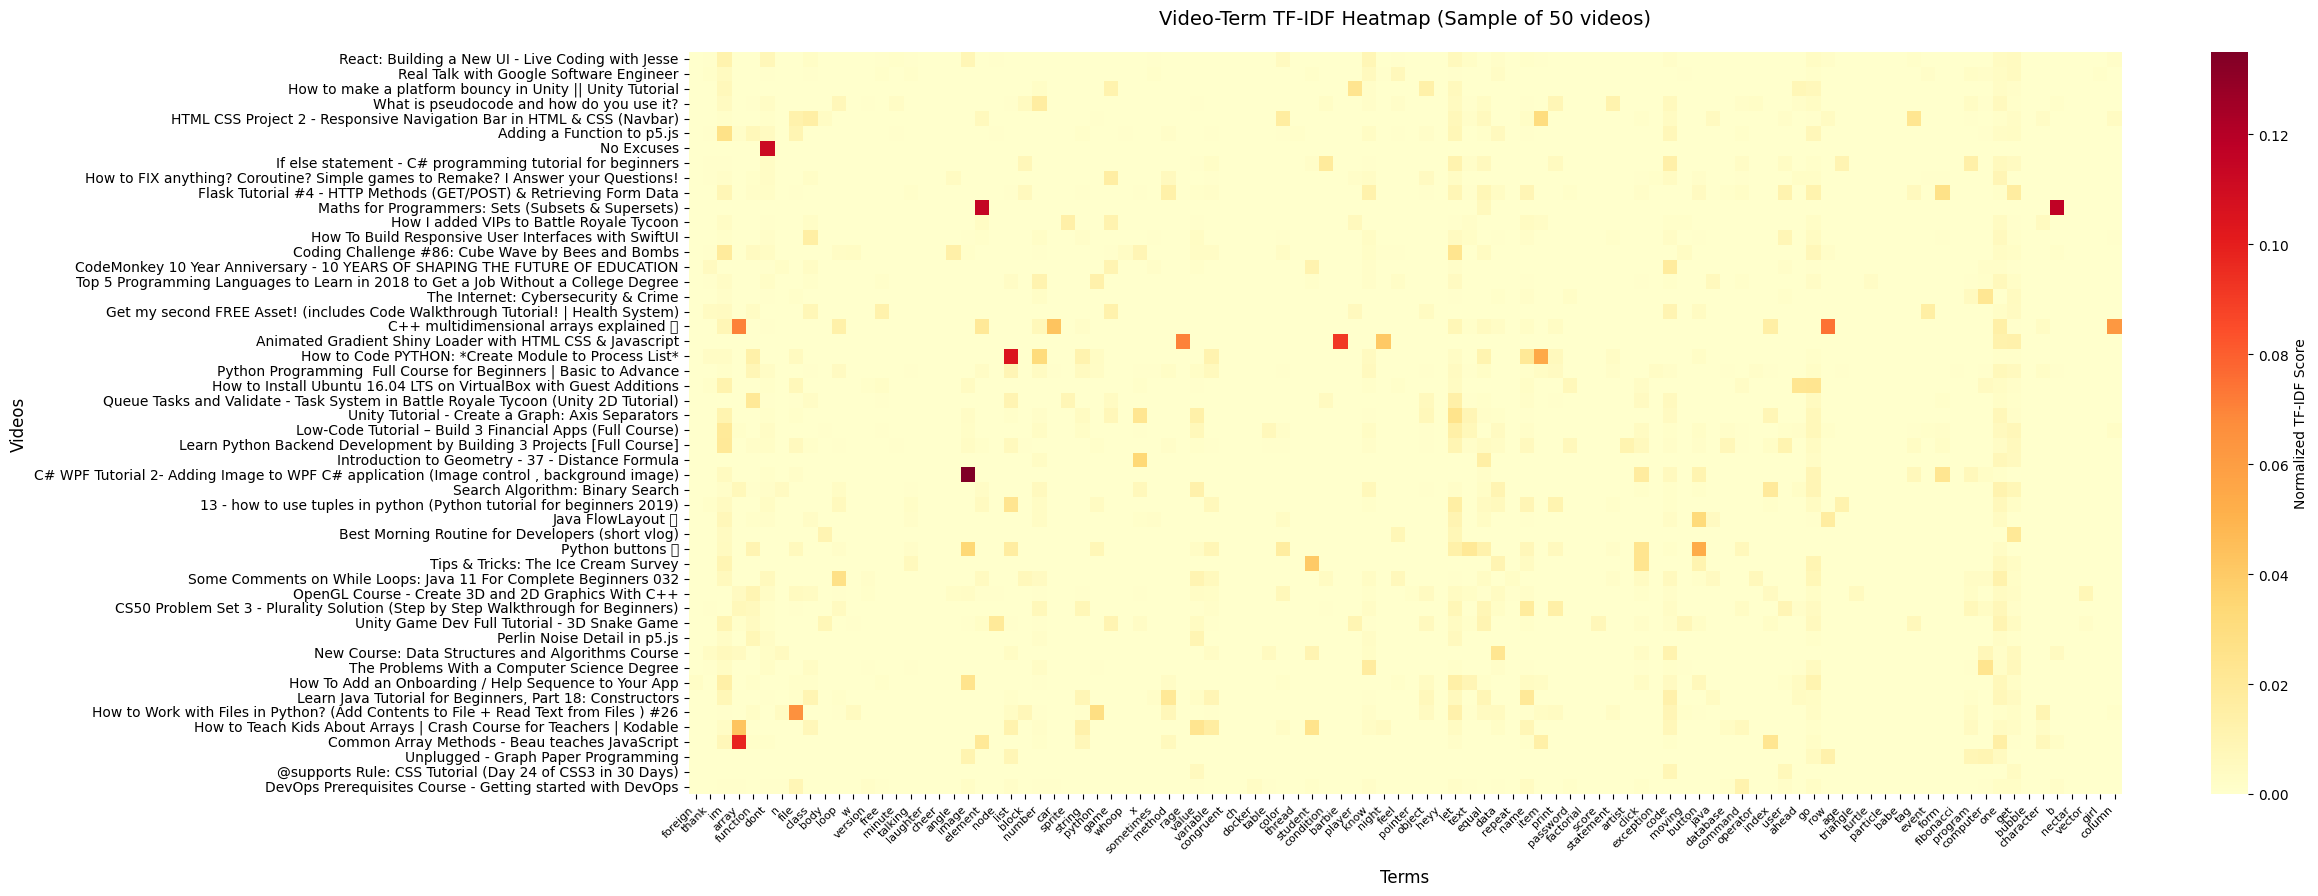

In [ ]:
# # Video-level heatmap visualization
# def plot_video_heatmap_batched(video_matrix, video_terms, video_labels, 
#                               n_videos=50, n_terms=100, figsize=(25, 10),
#                               batch_size=1000):
#     """
#     Create heatmap visualization for video-level TF-IDF matrix using batch processing
#     """
#     # Get top terms based on variance (process in batches)
#     n_samples, n_features = video_matrix.shape
#     variance = np.zeros(n_features)
#     n_batches = (n_samples - 1) // batch_size + 1
    
#     print("Calculating variance in batches...")
#     for i in range(n_batches):
#         start_idx = i * batch_size
#         end_idx = min((i + 1) * batch_size, n_samples)
        
#         # Process batch
#         batch_matrix = video_matrix[start_idx:end_idx].toarray()
#         batch_variance = np.var(batch_matrix, axis=0)
#         variance += batch_variance
    
#     # Normalize variance by number of batches
#     variance /= n_batches
    
#     # Get top term indices
#     top_term_indices = np.argsort(-variance)[:n_terms]
    
#     # Select random videos
#     video_indices = np.random.choice(video_matrix.shape[0], n_videos, replace=False)
    
#     # Create subset matrix (process selected videos in batches if needed)
#     if n_videos > batch_size:
#         subset_batches = []
#         video_batch_size = batch_size
#         n_video_batches = (n_videos - 1) // video_batch_size + 1
        
#         for i in range(n_video_batches):
#             start_idx = i * video_batch_size
#             end_idx = min((i + 1) * video_batch_size, n_videos)
#             batch_indices = video_indices[start_idx:end_idx]
            
#             batch_matrix = video_matrix[batch_indices][:, top_term_indices].toarray()
#             subset_batches.append(batch_matrix)
        
#         subset_matrix = np.vstack(subset_batches)
#     else:
#         subset_matrix = video_matrix[video_indices][:, top_term_indices].toarray()
    
#     # Create labels
#     term_labels = [video_terms[i] for i in top_term_indices]
#     video_labels_subset = [video_labels[i] for i in video_indices]
    
#     # Create visualization
#     plt.figure(figsize=figsize)
    
#     # Create heatmap
#     sns.heatmap(subset_matrix, 
#                 xticklabels=term_labels,
#                 yticklabels=video_labels_subset,
#                 cmap='YlOrRd',
#                 cbar_kws={'label': 'Normalized TF-IDF Score'})
    
#     # Adjust labels
#     plt.xticks(rotation=45, ha='right', fontsize=8)
#     plt.yticks(fontsize=10)
    
#     # Add labels and title
#     plt.xlabel('Terms', fontsize=12, labelpad=10)
#     plt.ylabel('Videos', fontsize=12)
#     plt.title(f'Video-Term TF-IDF Heatmap (Sample of {n_videos} videos)', 
#              fontsize=14, 
#              pad=20)
    
#     # Adjust layout
#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.2)
    
#     # Save figure
#     plt.savefig('video_tfidf_heatmap.png', 
#                 dpi=300, 
#                 bbox_inches='tight',
#                 pad_inches=0.5)
    
#     plt.show()

# # Create video heatmap with batch processing
# plot_video_heatmap_batched(video_matrix, 
#                           video_terms, 
#                           video_labels,
#                           n_videos=50,
#                           n_terms=100,
#                           figsize=(25, 10),
#                           batch_size=1000)

### Okay, it looks like we've got the matrix but it's practically hard to interpret due to the sheer scale. Instead, let's produce Normalized TF-IDF tables per YouTube Channel and save them as .csv (.png is too computationally big); we can rudimentally compare channels this way by showing the tables side-by-side, but eventually we can add implementation to compare channel's Normalized TF-IDFs.

Again, the normalized TF-IDF tells us words that are frequently used within a specific YouTube Channel (high TF) and words that are relatively unique to that YouTube Channel compared to other channels (high IDF).

Interpretation Guidelines:
- High Scores (close to 1)
    - Words that are distinctively characteristic to a specific channel:
        - Words that define the channel's unique content forcus
        - Technical or specialized vocabulary to that channel's niche
- Low Scores (close to 0)
    - Common words used across many channels:
        - General programming or coding terms that appear everywhere
        - "Non-distinctive" vocabulary

In [11]:
# produce Normalized TF-IDF tables per YouTube Channel and save them as .csv
def save_channel_tfidf_to_csv(channel_matrix, channel_terms, df_metadata_transcript):
    """
    Save the normalized TF-IDF scores for each channel to CSV files
    """
    # Create directory if it doesn't exist
    output_dir = os.path.join('channel_normalized_tfidf_tables')
    os.makedirs(output_dir, exist_ok=True)
    
    channels = df_metadata_transcript['channel_name'].unique()
    
    for i, channel in enumerate(channels):
        try:
            # Get channel scores
            channel_scores = channel_matrix[i].toarray().flatten()
            
            # Create DataFrame with terms and scores
            channel_df = pd.DataFrame({
                'Term': channel_terms,
                'TF-IDF Score': channel_scores
            })
            
            # Sort by score and filter non-zero scores
            channel_df = channel_df.sort_values('TF-IDF Score', ascending=False)
            channel_df = channel_df[channel_df['TF-IDF Score'] > 0]
            
            # Create safe filename
            safe_channel_name = "".join(x for x in channel if x.isalnum() or x in (' ', '-', '_'))
            
            # Save as CSV
            csv_path = os.path.join(output_dir, f'{safe_channel_name}_normalized_tfidf_scores.csv')
            channel_df.to_csv(csv_path, index=False)
            
            print(f"Created table for channel: {channel}")
        except Exception as e:
            print(f"Error saving TF-IDF table for channel {channel}: {e}")

# Create normalized matrix for channels
channel_matrix, channel_terms, channel_labels = create_normalized_tfidf_matrix(df_metadata_transcript)

# Save to CSV files
save_channel_tfidf_to_csv(channel_matrix, channel_terms, df_metadata_transcript)

Fitting vocabulary...
Processing 17 batches...
Processing batch 1/17
Processing batch 2/17
Processing batch 3/17
Processing batch 4/17
Processing batch 5/17
Processing batch 6/17
Processing batch 7/17
Processing batch 8/17
Processing batch 9/17
Processing batch 10/17
Processing batch 11/17
Processing batch 12/17
Processing batch 13/17
Processing batch 14/17
Processing batch 15/17
Processing batch 16/17
Processing batch 17/17
Created table for channel: Black Girls Code
Created table for channel: Codecademy
Created table for channel: Coding for kids
Created table for channel: Scratch Team
Created table for channel: Code.org
Created table for channel: Khan Academy Computing
Created table for channel: Programiz
Created table for channel: Clear Code
Created table for channel: w3schools.com
Created table for channel: KidsCanCode
Created table for channel: Girls Who Code
Created table for channel: freeCodeCamp.org
Created table for channel: LearnCode.academy
Created table for channel: Code Mo